In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings

# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importation des librairies
import os
import io
import re
import gc
import itertools
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import plotly as pl
import plotly.express as px
import datetime as dt
import functools
import scipy.stats as st
import statsmodels.api as sm
import pyarrow.parquet as pq
import time as time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from math import prod
from sklearn import cluster
from collections import Counter
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, mean_squared_error,  r2_score, silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import shapiro, normaltest, anderson
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import check_random_state, shuffle
%matplotlib inline
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [ ]:
import pandas as pd

# Chemin vers le fichier merged_df.csv
csv_path = "/content/drive/MyDrive/openclass/merged_df.csv"

# Importer le fichier CSV dans un DataFrame
merged_df = pd.read_csv(csv_path)

# Afficher les premières lignes du DataFrame pour vérification
merged_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_order,order_id,order_status,order_purchase_timestamp,order_approved_at,...,product_length_cm,index_merged_translation,seller_zip_code_prefix,seller_city,seller_state,index_translation,product_category_name_english,commandes_par_clients,montant_cumule,duree_depuis_derniere_commande
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,88492,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,124.99,474
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,60047,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,112.99,297
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,60047,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,225.98,297
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,42931,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,124.99,483
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,32077,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,...,54.0,1182,8577,itaquaquecetuba,SP,30,office_furniture,1,106.99,211


# Encodage des variables

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Séparation des variables catégorielles et numériques
categorical_cols = [col for col in merged_df.columns if merged_df[col].dtype == 'object']
numeric_cols = [col for col in merged_df.columns if merged_df[col].dtype in ['int64', 'float64']]

# Création des transformateurs pour les variables catégorielles et numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Remplacement des valeurs manquantes par la médiane
    ('scaler', StandardScaler())  # Normalisation des valeurs numériques
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Remplacement des valeurs manquantes par 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encodage one-hot des variables catégorielles
])

# Application des transformations sur les colonnes respectives
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),  # Transformer les variables numériques
        ('cat', categorical_transformer, categorical_cols)  # Transformer les variables catégorielles
    ])

# Appliquer le prétraitement
transformed_data = preprocessor.fit_transform(merged_df)


# Réalisation d'un clustering de type K-means

In [ ]:
# Définir les noms des colonnes à sélectionner
colonnes_a_selectionner = ['duree_depuis_derniere_commande', 'commandes_par_clients', 'montant_cumule']

# Sélectionner les colonnes
df = merged_df.loc[:, colonnes_a_selectionner]
# Afficher le résultat
print(df)

        duree_depuis_derniere_commande  commandes_par_clients  montant_cumule
0                                  474                      1          124.99
1                                  297                      1          112.99
2                                  297                      1          225.98
3                                  483                      1          124.99
4                                  211                      1          106.99
...                                ...                    ...             ...
115604                             155                      1          389.00
115605                             511                      1           36.99
115606                             370                      1          139.00
115607                             398                      1          129.00
115608                             398                      1          258.00

[115609 rows x 3 columns]


In [ ]:
from sklearn.cluster import KMeans

# Définir le nombre de clusters
n_clusters = 3

# Créer l'instance de KMeans
kmeans = KMeans(n_clusters=n_clusters)

# Appliquer KMeans aux données transformées
labels = kmeans.fit_predict(transformed_data)

# Ajouter une nouvelle colonne pour les labels des clusters
df['cluster'] = labels
df

,duree_depuis_derniere_commande,commandes_par_clients,montant_cumule,cluster
0,474,1,124.99,1
1,297,1,112.99,1
2,297,1,225.98,1
3,483,1,124.99,1
4,211,1,106.99,1
...,...,...,...,...
115604,155,1,389.00,2
115605,511,1,36.99,0
115606,370,1,139.00,0
115607,398,1,129.00,0


Méthode de la silouhette

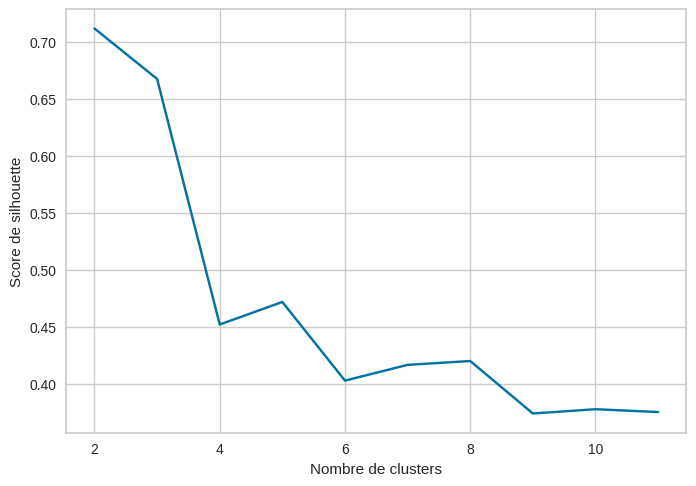

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import silhouette_score
# Sample a smaller subset of data (adjust sample_size based on your needs)
data_sample = resample(df, replace=False, n_samples=1000)

scores = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(data_sample)
    score = silhouette_score(data_sample, labels)
    scores.append(score)
plt.plot(range(2, 12), scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.show()


Avec la méthode de la silouhette le nombre de clusters optimal est de 4

Méthode du coude

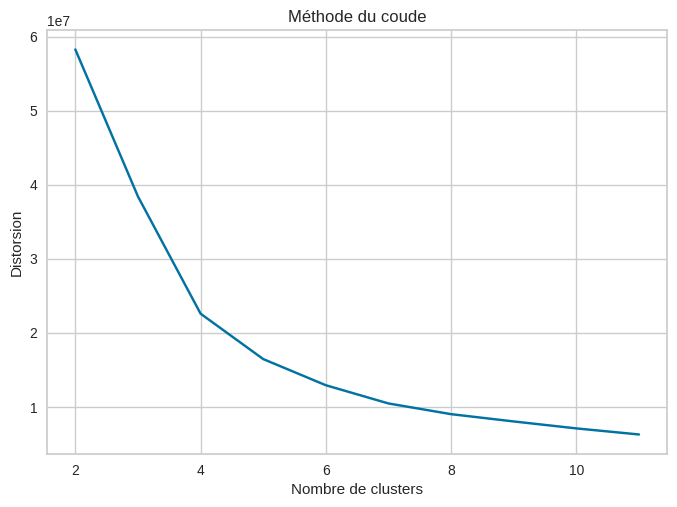

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Fonction pour calculer la distorsion
def compute_inertia(data, kmeans):
    return kmeans.inertia_

# Données d'entrée
X = data_sample

distortions = []
nums_clusters = range(2, 12)  # Nombre de clusters à tester

for k in nums_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(compute_inertia(X, kmeans))

# Tracer la courbe de la distorsion
plt.plot(nums_clusters, distortions, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distorsion')
plt.title('Méthode du coude')
plt.show()

Avec la méthode du coude le nombre optimal de cluster est de 4

On utilise le packages yellowbrick pour faire un graphique de distorsion avec 2 scores

In [ ]:
pip install yellowbrick`

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


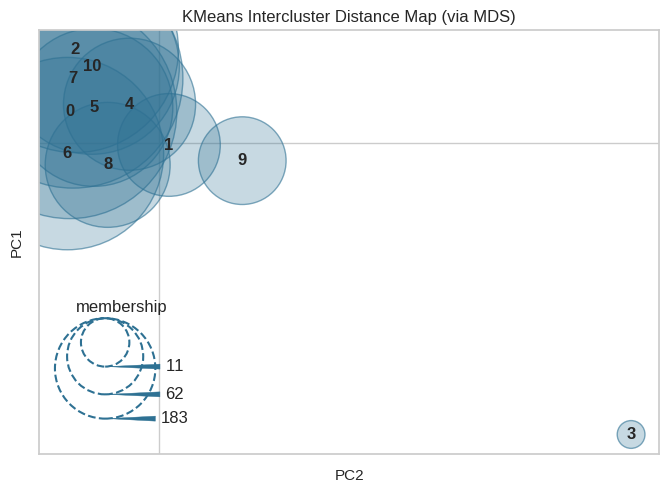

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [ ]:
from yellowbrick.cluster import InterclusterDistance
# Distance inter-clusters Map avec le meilleur k
distance_visualizer = InterclusterDistance(kmeans)
distance_visualizer.fit(df)
distance_visualizer.show()

Analyse statistique métier

Entrainement du modèle avec le nombre optimal de clusters

In [ ]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(transformed_data)

Vérification du nombre de personnes par cluster

In [ ]:
cluster_counts = pd.Series(labels).value_counts().sort_index()
print(cluster_counts)

0    17618
1    90931
2     7060
Name: count, dtype: int64


In [ ]:
df

,duree_depuis_derniere_commande,commandes_par_clients,montant_cumule,cluster
0,474,1,124.99,1
1,297,1,112.99,1
2,297,1,225.98,1
3,483,1,124.99,1
4,211,1,106.99,1
...,...,...,...,...
115604,155,1,389.00,2
115605,511,1,36.99,0
115606,370,1,139.00,0
115607,398,1,129.00,0


On réalise le boxplot de chaque variable par cluster

In [ ]:
df["commandes_par_clients"].value_counts()

commandes_par_clients
1     107405
2       7085
3        798
4        179
5         57
7         31
6         25
15        15
9         14
Name: count, dtype: int64

0    474
1    297
2    297
3    483
4    211
Name: duree_depuis_derniere_commande, dtype: int64


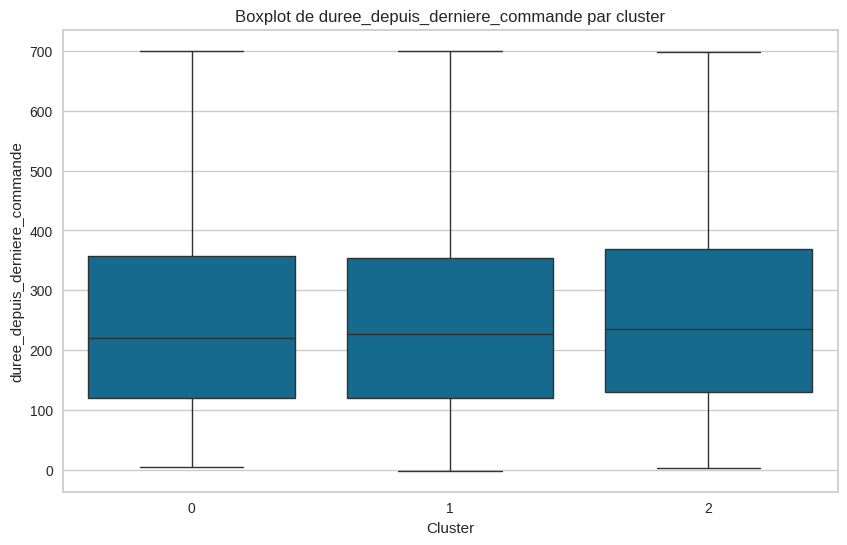

0    1
1    1
2    1
3    1
4    1
Name: commandes_par_clients, dtype: int64


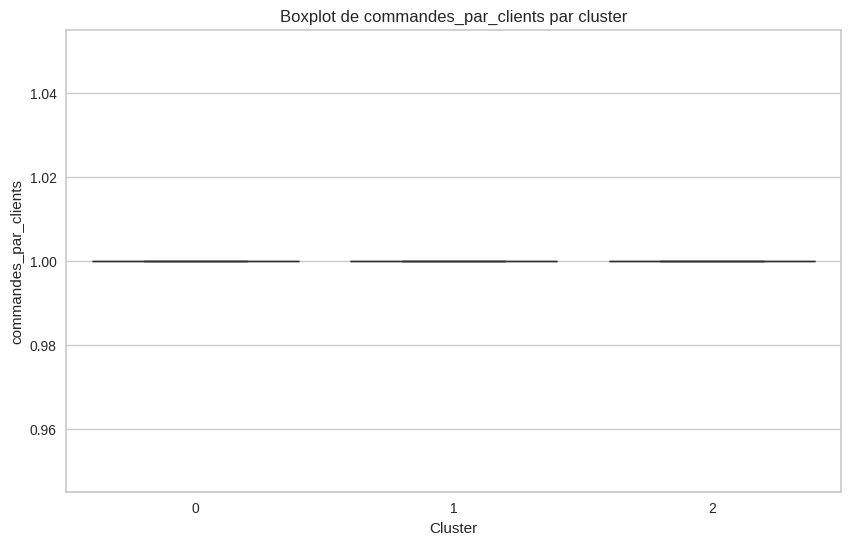

0    124.99
1    112.99
2    225.98
3    124.99
4    106.99
Name: montant_cumule, dtype: float64


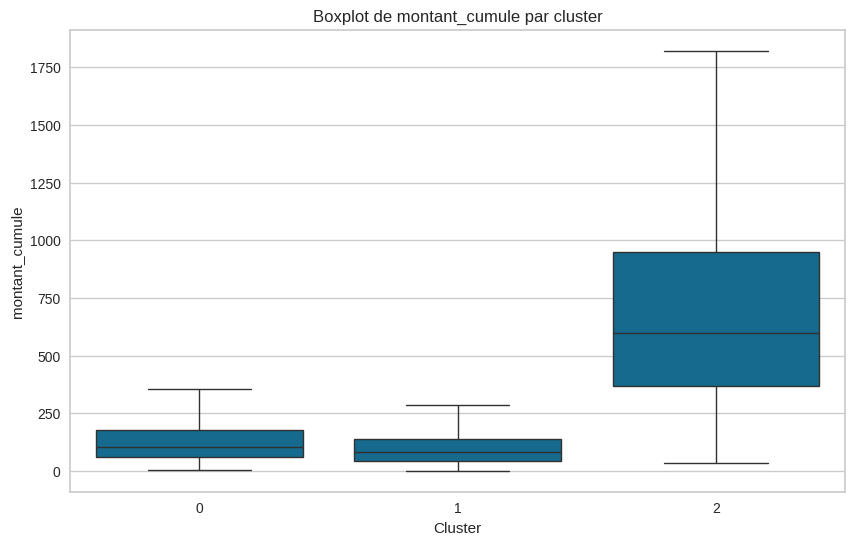

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de code pour créer un boxplot pour chaque cluster par variable
for column in df.columns[:-1]:  # Exclure la colonne 'cluster'
    print(df[column].head())
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=column, data=df, showfliers=False)
    plt.title(f'Boxplot de {column} par cluster')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()


Cluster 1: Clients qui concentrent la plus grosse part de dépense et avec la durée depuis la dernière commande plus élevée (17449)


Cluster 2: Clients qui concentrent une part de dépense plus faible et avec la durée depuis la dernière commande plus faible (9779)

Cluster 3: Clients qui concentrent moins de dépense et et avec la durée depuis la dernière commande faible (88381)

Boxplot pour chaque cluster par variable

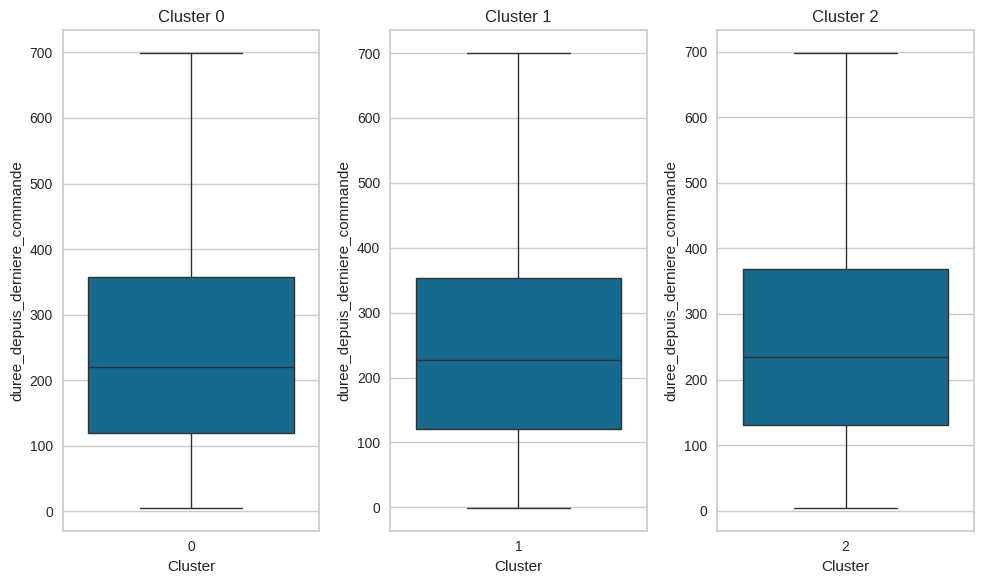

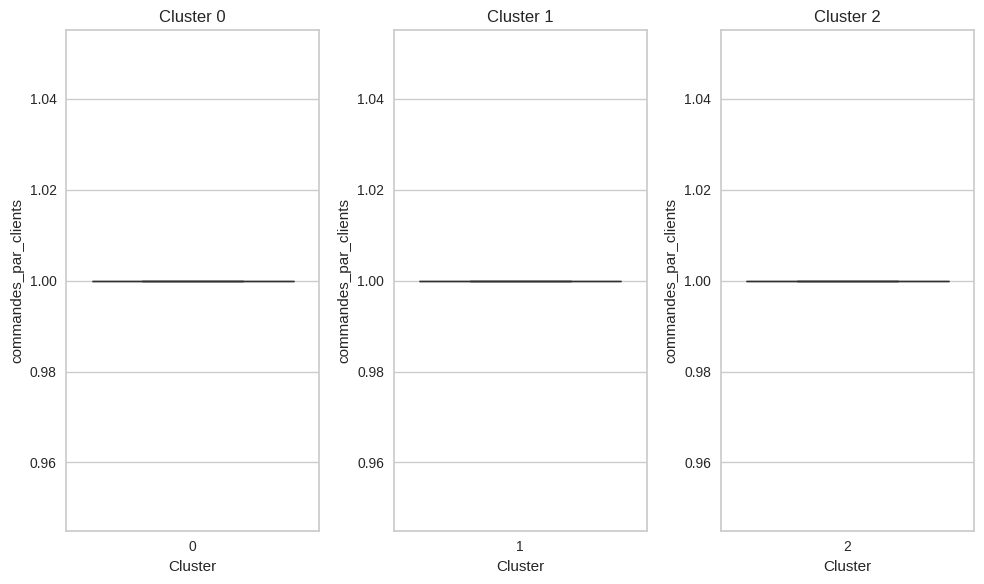

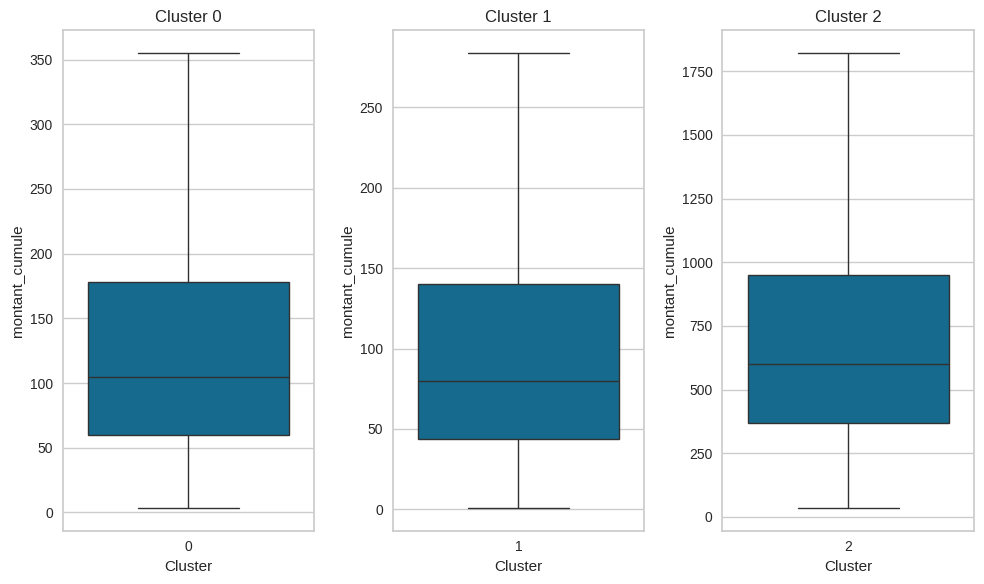

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que df est votre DataFrame

# Liste des noms de colonnes des variables à visualiser
columns_to_plot = df.columns[:-1]  # Exclure la colonne 'cluster'

# Boucle sur chaque variable pour créer les boxplots par cluster
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    for cluster in df['cluster'].unique():
        plt.subplot(1, len(df['cluster'].unique()), cluster + 1)
        sns.boxplot(x='cluster', y=column, data=df[df['cluster'] == cluster], showfliers=False)
        plt.title(f'Cluster {cluster}')
        plt.xlabel('Cluster')
        plt.ylabel(column)
    plt.tight_layout()
    plt.show()


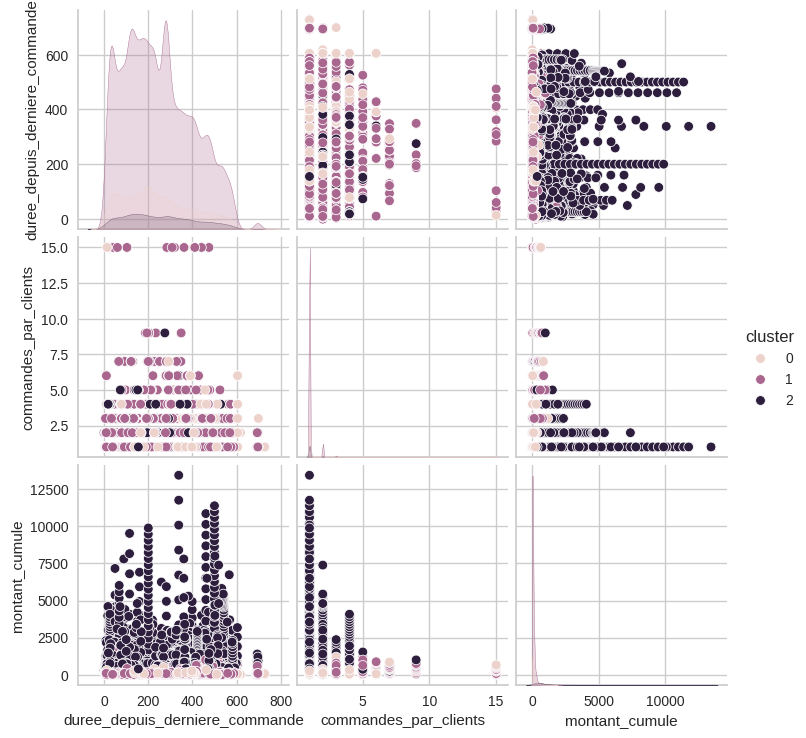

In [ ]:
# Analyse bivariée et trivariée
sns.pairplot(df, hue='cluster')  # Pour l'analyse bivariée
plt.show()

Diagramme RADAR pour chaque cluster

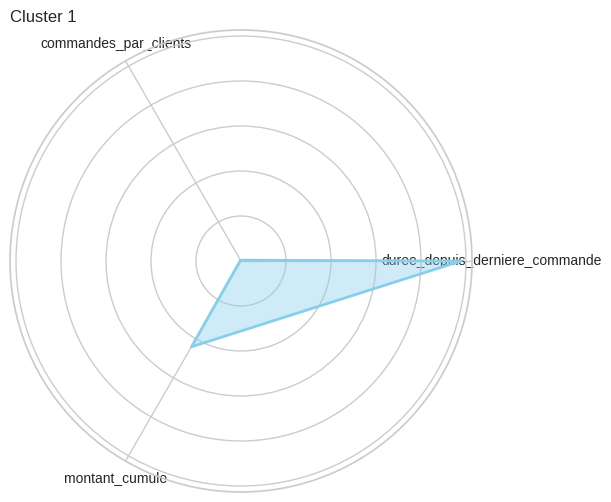

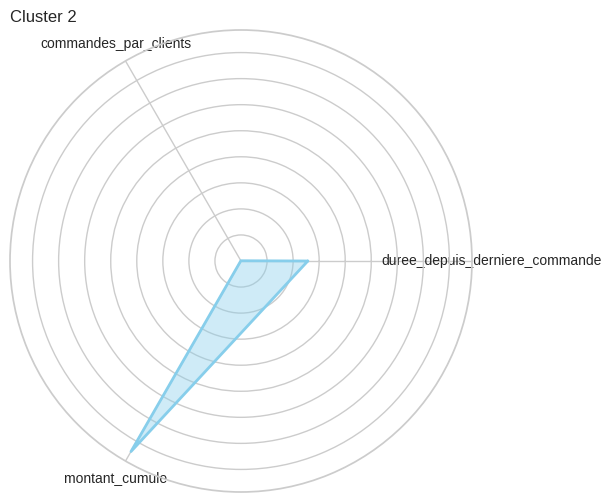

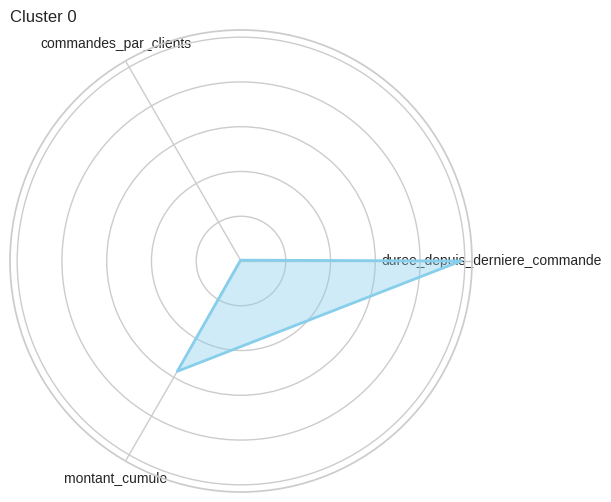

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour créer un diagramme radar
def radar_chart(features, values, cluster):
    num_features = len(features)
    # Création d'un angle pour chaque feature
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()

    # Concaténer la première feature à la fin pour fermer le cercle
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    # Création du graphique radar
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='skyblue', alpha=0.4)
    ax.plot(angles, values, color='skyblue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_title(f'Cluster {cluster}', loc='left')

# Caractéristiques à utiliser dans le diagramme radar
features = ['duree_depuis_derniere_commande', 'commandes_par_clients', 'montant_cumule']

# Diviser le DataFrame par cluster
for cluster in df['cluster'].unique():
    cluster_df = df[df['cluster'] == cluster]
    cluster_means = cluster_df.mean()[:-1]  # Exclure la colonne 'cluster'
    values = cluster_means.values
    radar_chart(features, values, cluster)

plt.show()


# On refait la meme chose avec d'autres features

In [ ]:
merged_df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'index_order', 'order_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'index_merged_reviews',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'index_reviews', 'review_id', 'review_score',
       'index_merged_products', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'index_products',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'index_merged_translation', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'index_translation', 'product_category_name_english',
       'commandes_par_clients', 'montant_cumule',
       'duree_depuis_derniere_commande'],
      dtype='object')

In [ ]:
#Selection d'autres variables
df_new = merged_df[['product_weight_g', 'review_score', 'duree_depuis_derniere_commande', 'commandes_par_clients', 'montant_cumule']]

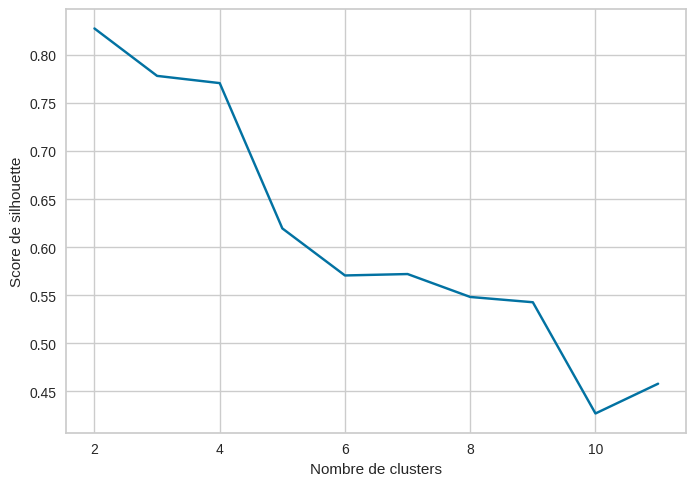

In [ ]:
#On choisit le nombre optimal de cluster à l'aide de laméthode de la silouhette
from sklearn.utils import resample
from sklearn.metrics import silhouette_score
# Sample a smaller subset of data (adjust sample_size based on your needs)
data_sample = resample(df_new, replace=False, n_samples=1000)

scores = []
for k in range(2, 12):
    kmeansnew = KMeans(n_clusters=k)
    labels = kmeansnew.fit_predict(data_sample)
    score = silhouette_score(data_sample, labels)
    scores.append(score)
plt.plot(range(2, 12), scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.show()


Le nombre optimal de clusters est ici de 4

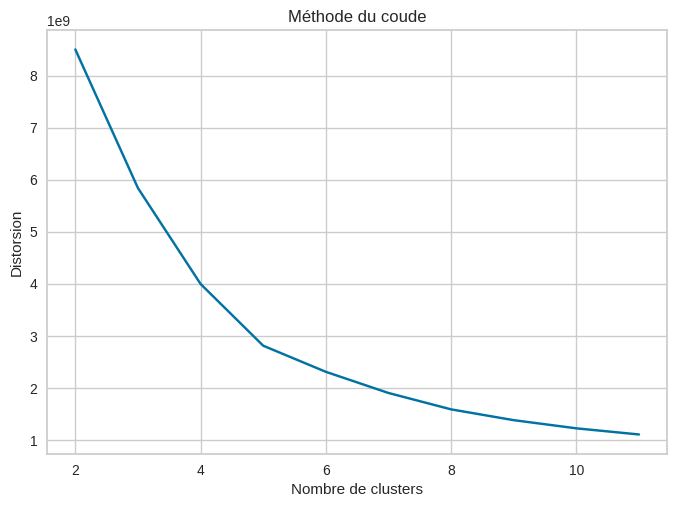

In [ ]:
#On passe à la méthode du coude
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Fonction pour calculer la distorsion
def compute_inertia(data, kmeansnew):
    return kmeansnew.inertia_

# Données d'entrée
X = df

distortions = []
nums_clusters = range(2, 12)  # Nombre de clusters à tester

for k in nums_clusters:
    kmeansnew = KMeans(n_clusters=k)
    kmeansnew.fit(X)
    distortions.append(compute_inertia(X, kmeansnew))

# Tracer la courbe de la distorsion
plt.plot(nums_clusters, distortions, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distorsion')
plt.title('Méthode du coude')
plt.show()

Le nombre optimal de clusters est ici de 5

In [ ]:
#On réalise notre Kmeans avec le nombre optimal de 4 clusters
kmeansnew = KMeans(n_clusters=4)
labels = kmeansnew.fit_predict(df_new)
df_new['cluster'] = labels

<ipython-input-23-eab1a4aac706>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['cluster'] = labels


In [ ]:
#Vérification du nombre d'individus par cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()
print(cluster_counts)

0    11734
1     5352
2     1151
3    97372
Name: count, dtype: int64


In [ ]:
df_new

,product_weight_g,review_score,duree_depuis_derniere_commande,commandes_par_clients,montant_cumule,cluster
0,8683.0,4,474,1,124.99,0
1,8683.0,1,297,1,112.99,0
2,8683.0,1,297,1,225.98,0
3,8683.0,3,483,1,124.99,0
4,8683.0,4,211,1,106.99,0
...,...,...,...,...,...,...
115604,12500.0,4,155,1,389.00,1
115605,450.0,1,511,1,36.99,3
115606,2200.0,5,370,1,139.00,3
115607,2700.0,5,398,1,129.00,3


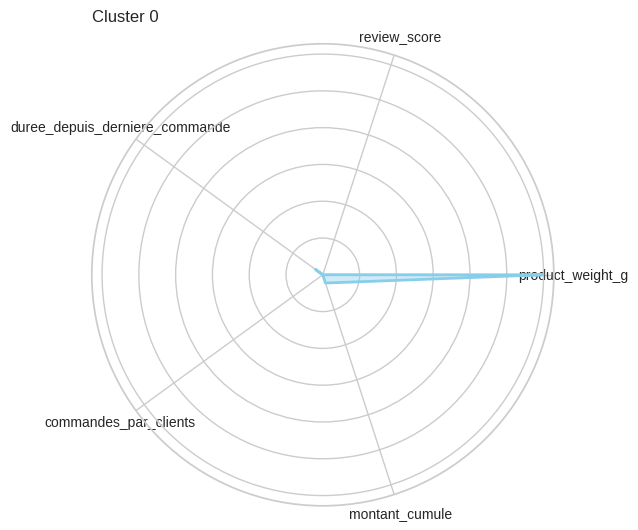

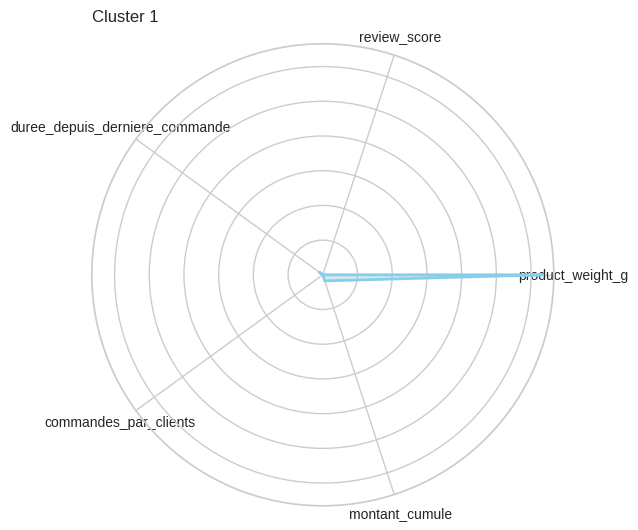

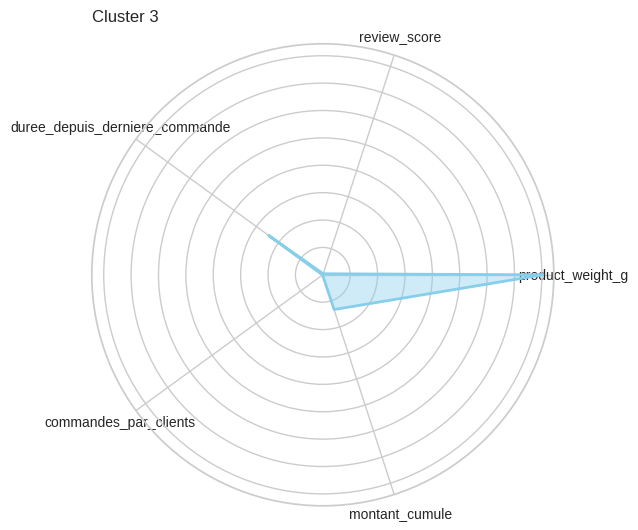

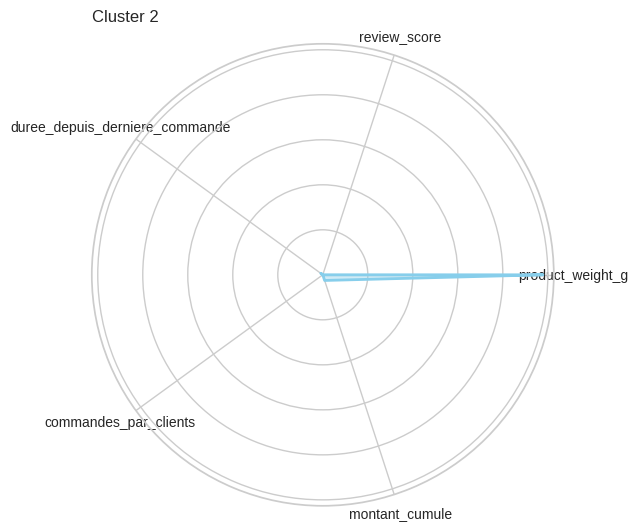

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Caractéristiques à utiliser dans le diagramme radar
features = ['product_weight_g', 'review_score', 'duree_depuis_derniere_commande', 'commandes_par_clients', 'montant_cumule']

# Diviser le DataFrame par cluster
for cluster in df_new['cluster'].unique():
    cluster_df = df_new[df_new['cluster'] == cluster]
    cluster_means = cluster_df.mean()[:-1]  # Exclure la colonne 'cluster'
    values = cluster_means.values
    radar_chart(features, values, cluster)

plt.show()


# On fait l'algorithme de DBSCAN

In [ ]:
# Sélectionner les données RFM
rfm = merged_df.loc[:, colonnes_a_selectionner]

# Instancier le préprocesseur (dans ce cas, un StandardScaler)
preprocessor = StandardScaler()

# Ajuster et transformer les données RFM
rfm_scaled = pd.DataFrame(preprocessor.fit_transform(rfm), index=rfm.index, columns=rfm.columns)

# Afficher les premières lignes des données RFM mises à l'échelle
print(rfm_scaled.head())

   duree_depuis_derniere_commande  commandes_par_clients  montant_cumule
0                        1.488889              -0.224091       -0.110877
1                        0.335822              -0.224091       -0.149044
2                        0.335822              -0.224091        0.210330
3                        1.547519              -0.224091       -0.110877
4                       -0.224425              -0.224091       -0.168128


In [ ]:
# Définition de la taille de l'échantillon
s = 1000

# Échantillonnage aléatoire avec une graine fixée pour la reproductibilité
X = rfm.sample(n=s, random_state=0).copy()

# Mise à l'échelle des données pour les préparer à l'analyse
X_scaled = pd.DataFrame(preprocessor.fit_transform(X),
                        index=X.index,
                        columns=X.columns)

# Importation de la classe NearestNeighbors pour déterminer les voisins les plus proches de chaque observation ainsi que les distances
from sklearn.neighbors import NearestNeighbors

# Initialisation du modèle NearestNeighbors avec 2 voisins
neigh = NearestNeighbors(n_neighbors=2)

# Ajustement du modèle NearestNeighbors aux données mises à l'échelle
nbrs = neigh.fit(X_scaled)

# Calcul des distances et des indices des voisins les plus proches
distances, indices = nbrs.kneighbors(X_scaled)

# Tri des distances pour obtenir la distance au voisin le plus proche pour chaque observation
distances = np.sort(distances, axis=0)
dist = distances[:, 1]

In [ ]:
pip install kneed

0.11160104727621505


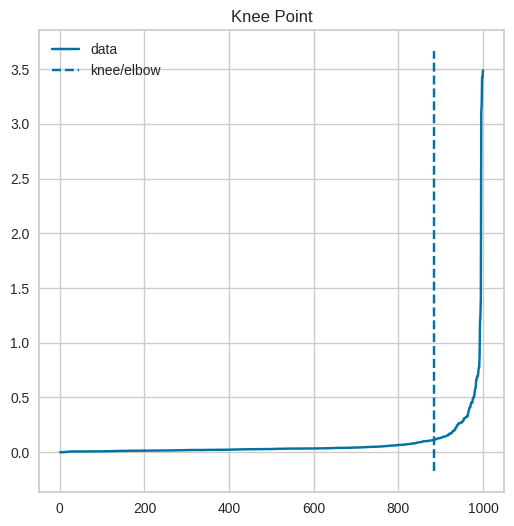

In [ ]:
from kneed import KneeLocator
kneedle = KneeLocator(x=range(1, len(distances)+1), y=dist, S=10,
                      curve="convex", direction="increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

kneedle.plot_knee()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
db_rfm = DBSCAN(eps=0.0008, min_samples=6, n_jobs=-1)
db_rfm.fit(rfm_scaled)

DBSCAN(eps=0.0008, min_samples=6, n_jobs=-1)

In [ ]:
labels = db_rfm.labels_

# Pour obtenir le nombre de clusters
# Comptez le nombre unique de labels, en tenant compte du fait que -1 est le label pour les points considérés comme du bruit
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print("Nombre de clusters:", num_clusters)

Nombre de clusters: 1997


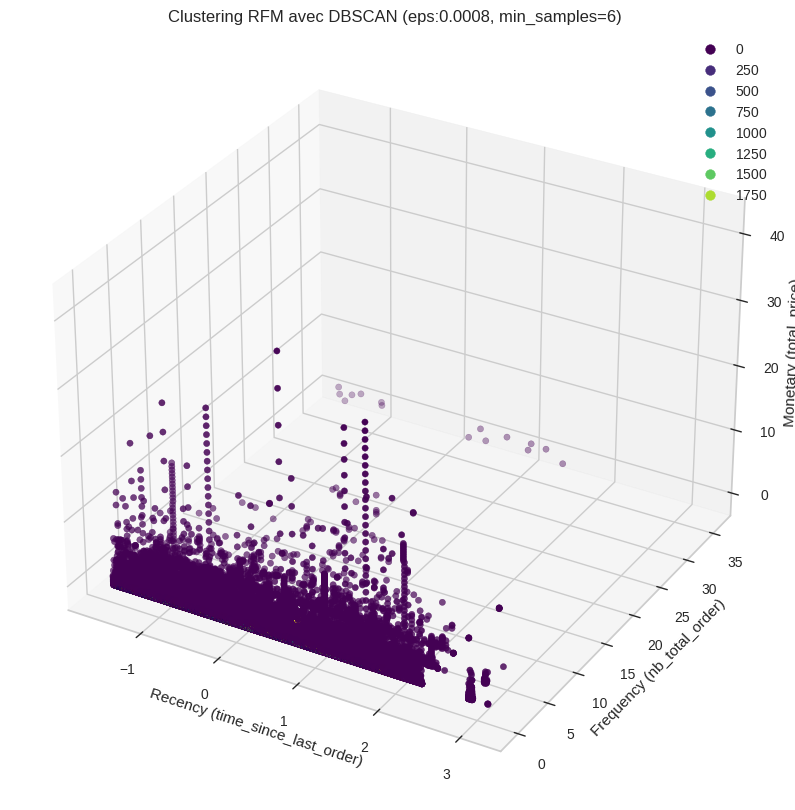

In [ ]:
# Récupération des étiquettes de cluster attribuées par DBSCAN
db_lab = db_rfm.labels_

# Création de la figure pour la visualisation en 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Tracé du nuage de points avec les données RFM mises à l'échelle, colorées par les étiquettes de cluster
scatter = ax.scatter(rfm_scaled.iloc[:, 0],
                     rfm_scaled.iloc[:, 1],
                     rfm_scaled.iloc[:, 2],
                     c=db_lab, cmap='viridis')


# Ajout d'une légende basée sur les couleurs des étiquettes de cluster
ax.legend(*scatter.legend_elements())

# Définition des labels des axes x, y et z
ax.set_xlabel('Recency (time_since_last_order)')
ax.set_ylabel('Frequency (nb_total_order)')
ax.set_zlabel('Monetary (total_price)')

# Définition du titre du graphique
ax.set_title('Clustering RFM avec DBSCAN (eps:0.0008, min_samples=6)')

# Affichage du graphique
plt.show()


In [ ]:
# Import des fonctions pour évaluer les performances du clustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Affichage du nombre de clusters identifiés par le modèle DBSCAN
print('Nombre de clusters avec le modèle DBSCAN: ',
      len(set(db_lab)) - (1 if -1 in db_lab else 0))

# Affichage du nombre de points considérés comme du bruit par DBSCAN
print('Nombre de points considérés comme du bruit: ', list(db_lab).count(-1))

# Calcul et affichage du Silhouette Score pour évaluer la cohésion et la séparation des clusters
print('Silhouette Score : ', silhouette_score(rfm_scaled, db_lab))

# Calcul et affichage du Davies Bouldin Score pour évaluer la compacité et la séparation des clusters
print('Davies Bouldin Score : ', davies_bouldin_score(rfm_scaled, db_lab))

# Calcul et affichage du Calinski Harabasz Score pour évaluer la cohésion et la séparation des clusters
print('Calinski Harabasz Score : ', calinski_harabasz_score(rfm_scaled,
                                                            db_lab))


Nombre de clusters avec le modèle DBSCAN:  1997
Nombre de points considérés comme du bruit:  99672
Silhouette Score :  -0.6149737129377433
Davies Bouldin Score :  1.856426342686522
Calinski Harabasz Score :  2.2636117065364174


Réalisation de CAH

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# Sélection d'un échantillon de données si nécessaire
sample_data = merged_df.sample(n=1000, random_state=42)

# Sélection des variables à utiliser pour la classification
X = sample_data.drop(columns=["duree_depuis_derniere_commande", "commandes_par_clients", "montant_cumule"])

# Sélection des colonnes catégorielles pour l'encodage
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Sélection des colonnes numériques
numerical_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()

# Transformation des données catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'
)

# Mise à l'échelle des données
X_scaled = preprocessor.fit_transform(X)

# Convertir la matrice creuse en matrice dense
X_dense = csr_matrix.toarray(X_scaled)

# Classification ascendante hiérarchique
clustering = AgglomerativeClustering(n_clusters=5)  # Choisir le nombre de clusters souhaité
cluster_labels = clustering.fit_predict(X_dense)


In [ ]:
# Taille de cluster_labels
print("Taille de cluster_labels:", cluster_labels.shape)

# Taille de X_scaled
print("Taille de X_scaled:", X_scaled.shape)


Taille de cluster_labels: (1000,)
Taille de X_scaled: (1000, 11371)


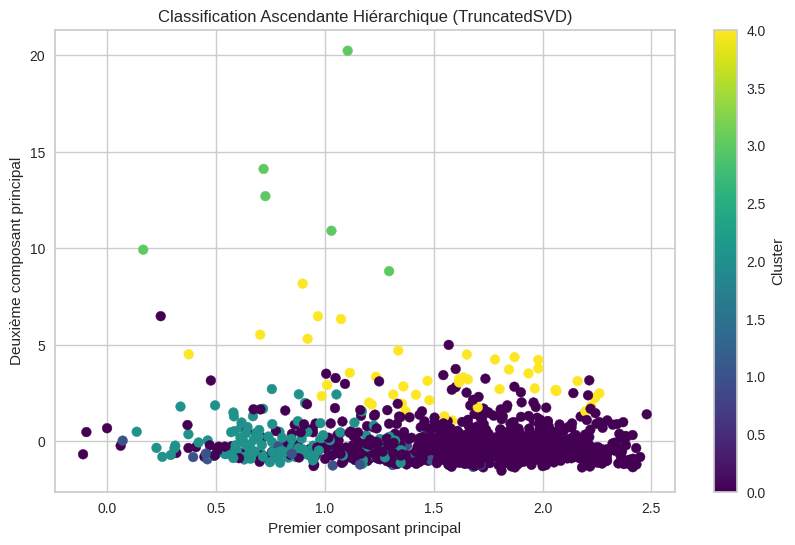

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Réduction de la dimensionnalité avec TruncatedSVD
svd = TruncatedSVD(n_components=2)  # Réduire les données en 2 dimensions
X_svd = svd.fit_transform(X_scaled)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Classification Ascendante Hiérarchique (TruncatedSVD)")
plt.xlabel("Premier composant principal")
plt.ylabel("Deuxième composant principal")
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# Convertir la matrice creuse en matrice dense
X_dense = X_scaled.toarray()

# Calcul des liens hiérarchiques
Z = linkage(X_dense, method='ward')  # Méthode de regroupement des données


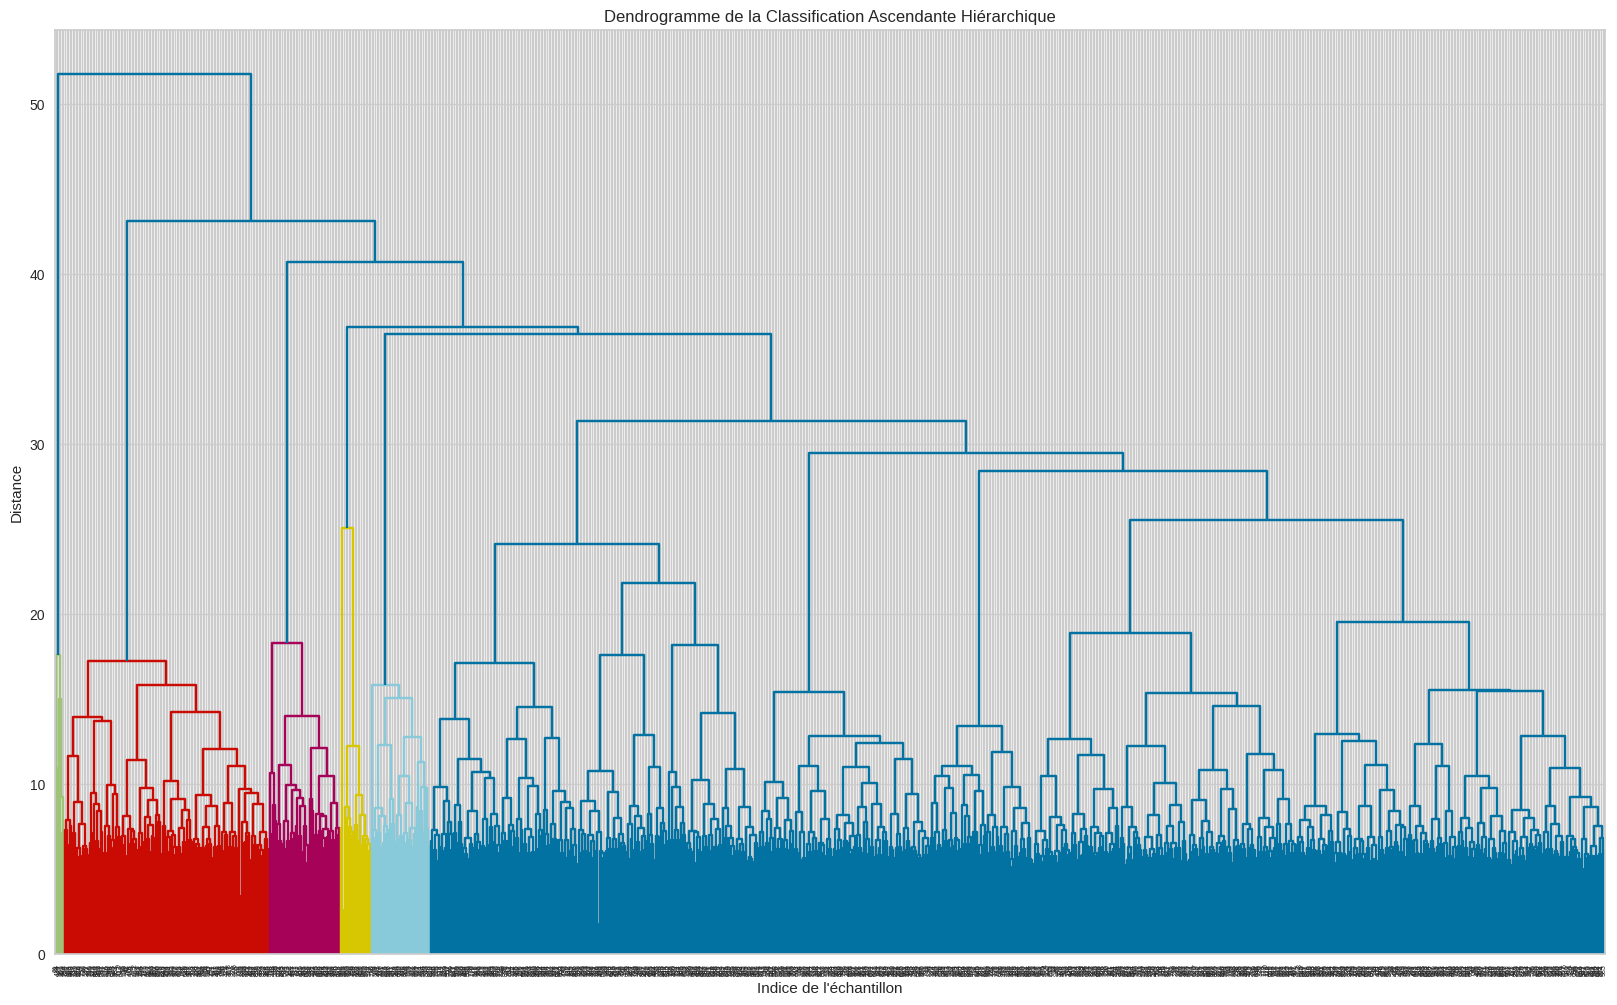

In [ ]:
# Tracé du dendrogramme
plt.figure(figsize=(20, 12))
dendrogram(Z)
plt.title("Dendrogramme de la Classification Ascendante Hiérarchique")
plt.xlabel("Indice de l'échantillon")
plt.ylabel("Distance")
plt.show()


Le dendrogramme nous permet d'observer que 2, 3 ou 4 clusters semblent être des séparations idéales.



In [ ]:
df_new.to_csv("/content/drive/MyDrive/openclass/df_new.csv", index=False)